In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose

Read the data

In [2]:
df = pd.read_csv('final_data.csv')
df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     1  2010-02-12      46039.49       True        38.51       2.548   
2      1     1  2010-02-19      41595.55      False        39.93       2.514   
3      1     1  2010-02-26      19403.54      False        46.63       2.561   
4      1     1  2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...  Weekly_Sales_MA4  Weekly_Sales_Std2  \
0        0.0        0.0        0.0  ...               NaN                NaN   
1        0.0        0.0        0.0  ...               NaN       14930.552614   
2        0.0        0.0        0.0  ...               NaN        3142.340109   
3        0.0        0.0        0.0  ...          32990.77       15692.120759   
4        0.0        0.0        0.0  ...          32216.62        1714.281396   

   Weekly_Sales_Std4  Weekly_Sales_Lag52 Weekly_Sales_Seasonal  Type_Encoded  \
0                NaN                 NaN                   NaN             2   
1                NaN                 NaN                   NaN             2   
2                NaN                 NaN                   NaN             2   
3       12832.106391                 NaN                   NaN             2   
4       13554.047185                 NaN                   NaN             2   

   Size_Normalized  store_cont  dept_cont    Set  
0         0.239209    0.012609   0.022371  train  
1         0.239209    0.023291   0.041323  train  
2         0.239209    0.021043   0.037334  train  
3         0.239209    0.009816   0.017416  train  
4         0.239209    0.011042   0.019592  train  

[5 rows x 54 columns]

In [3]:
train  = df[df['Set'] == 'train']
test  = df[df['Set'] == 'test']
print(train.shape)
print(test.shape)


(374203, 54)
(47367, 54)


Filtering for store and dept combinations with full time period

In [4]:
# Find all (Store, Dept) combinations with full 143 weeks of data
full_combinations = (
    df.groupby(['Store', 'Dept'])
    .size()
    .reset_index(name='Count')
    .query('Count == 143')[['Store', 'Dept']]
)

# Filter df to only those (Store, Dept) combinations
df = df.merge(full_combinations, on=['Store', 'Dept'], how='inner')
print(df.shape)
print(df[['Store', 'Dept']].value_counts())

(380380, 54)
Store  Dept
1      1       143
28     83      143
       87      143
       90      143
       91      143
              ... 
14     90      143
       91      143
       92      143
       93      143
45     97      143
Name: count, Length: 2660, dtype: int64


## Univariate Holtz winter model

In [5]:
def holtz_winter_model(df, store, dept):
    # Filter data for Store and Dept
    s1d1 = df[(df['Store'] == store) & (df['Dept'] == dept)].copy()

    # Convert 'Date' to datetime and set as index
    s1d1['Date'] = pd.to_datetime(s1d1['Date'])
    s1d1 = s1d1.set_index('Date')

    # Separate train and test sets
    train_s1d1 = s1d1[s1d1['Set'] == 'train']['Weekly_Sales']
    test_s1d1 = s1d1[s1d1['Set'] == 'test']['Weekly_Sales']

    # Build and train the Holt-Winters model
    # Using additive trend and seasonality, with a seasonal period of 52 weeks (for yearly seasonality)
    model = ExponentialSmoothing(train_s1d1, seasonal_periods=52, trend='add', seasonal='add').fit()

    # Make predictions on the test set
    predictions = model.forecast(len(test_s1d1))

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(test_s1d1, predictions))
    mape = mean_absolute_percentage_error(test_s1d1, predictions)



    if store == 1 and dept <= 10:
        print(f"Holt-Winters Model for Store {store}, Dept {dept}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2%}")

        # Plot the results
        plt.figure(figsize=(15, 7))
        plt.plot(train_s1d1.index, train_s1d1, label='Train')
        plt.plot(test_s1d1.index, test_s1d1, label='Test (Actual Sales)')
        plt.plot(predictions.index, predictions, label='Holt-Winters Predictions')
        plt.title('Holt-Winters Forecast vs Actuals for Store 1, Dept 1')
        plt.xlabel('Date')
        plt.ylabel('Weekly Sales')
        plt.legend()
        plt.grid(True)
        plt.show()

    results = [store, dept, rmse, mape]
    return results

Holt-Winters Model for Store 1, Dept 1:
RMSE: 2932.58
MAPE: 6.97%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


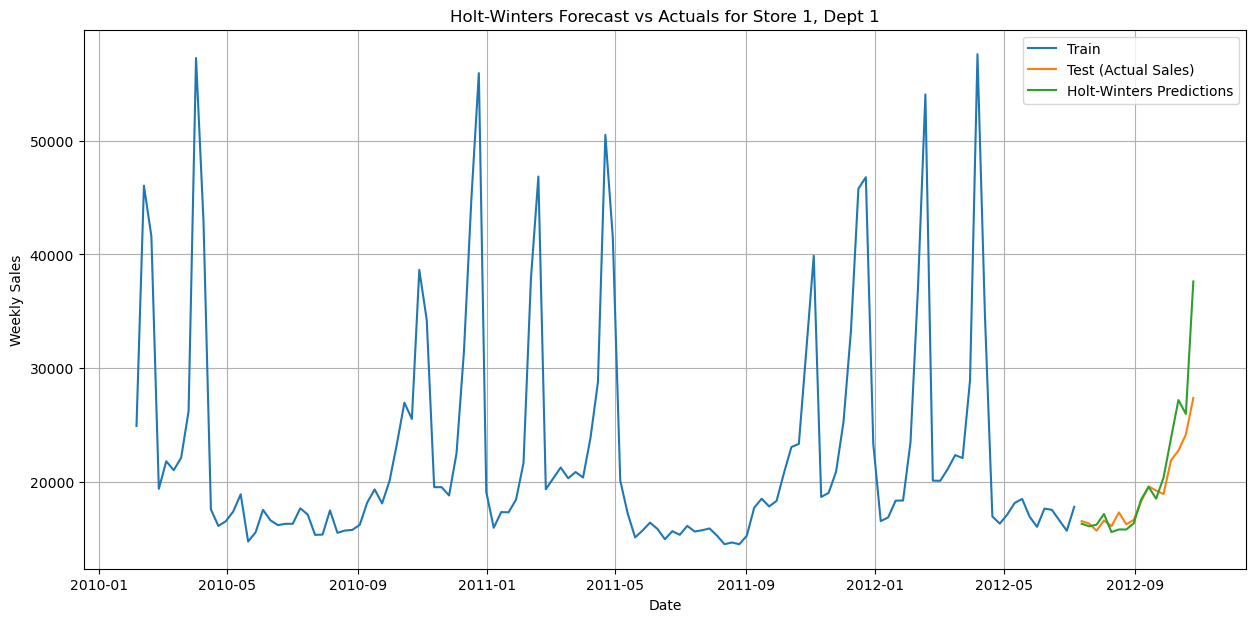

Holt-Winters Model for Store 1, Dept 2:
RMSE: 3819.11
MAPE: 7.50%


/var/folders/c7/9xbj4rnx7mj0nftwxf44my6m0000gp/T/ipykernel_90579/35706659.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hw_results_df = pd.concat(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


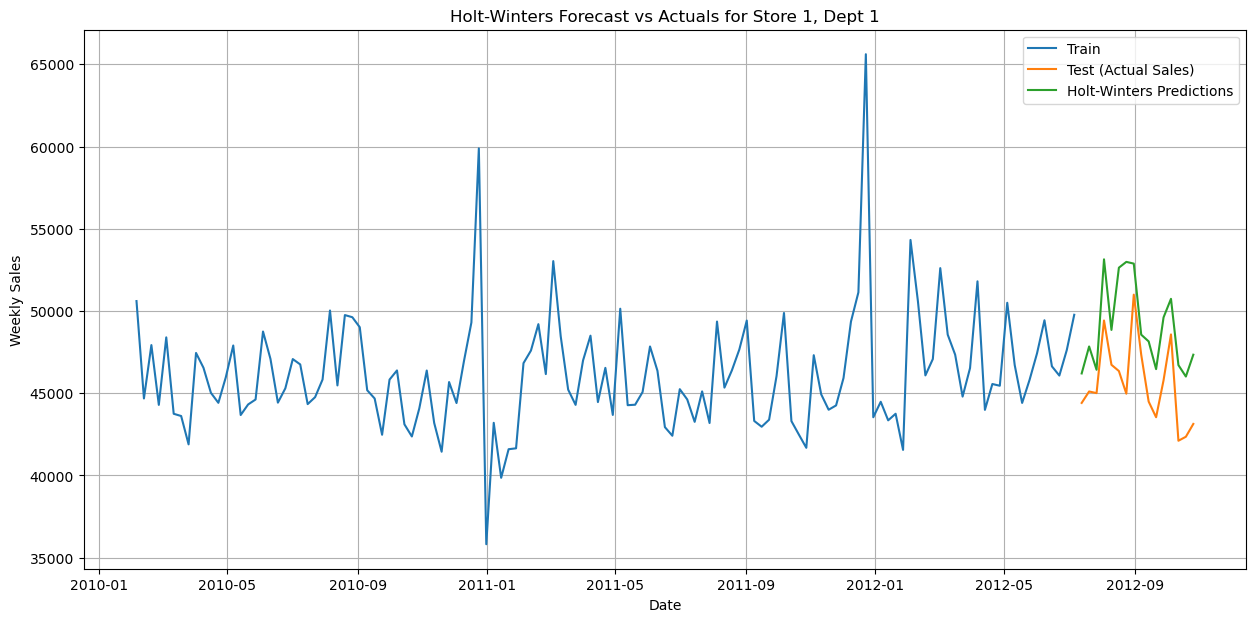

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters Model for Store 1, Dept 3:
RMSE: 8834.71
MAPE: 18.93%


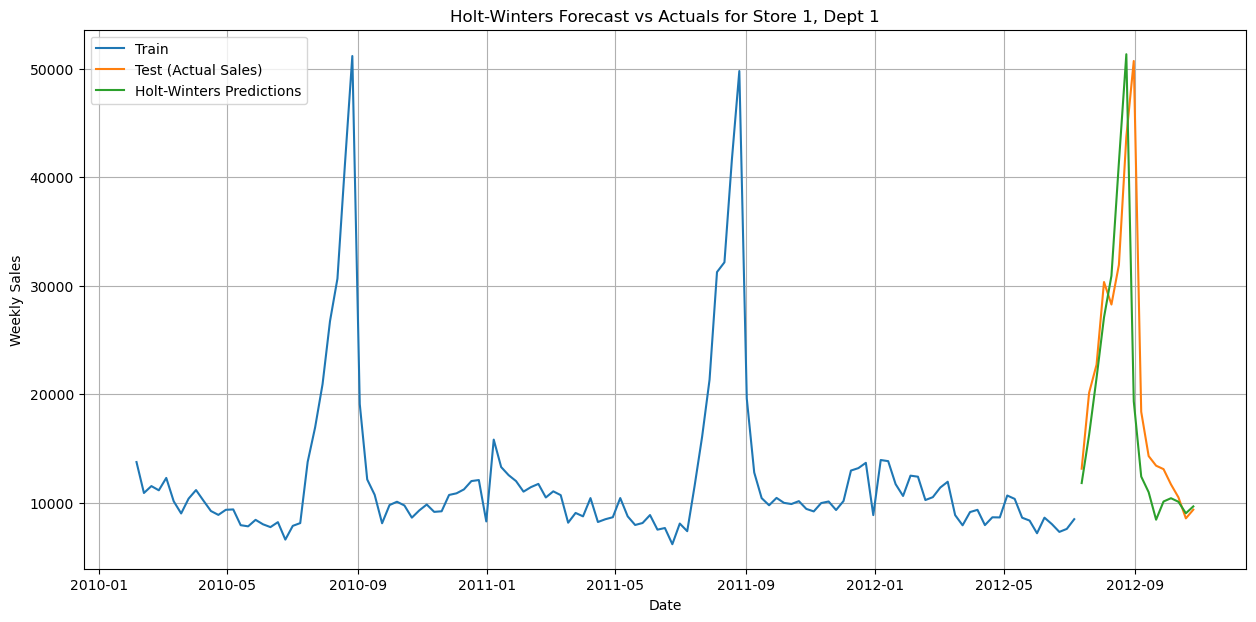

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters Model for Store 1, Dept 4:
RMSE: 3131.64
MAPE: 7.35%


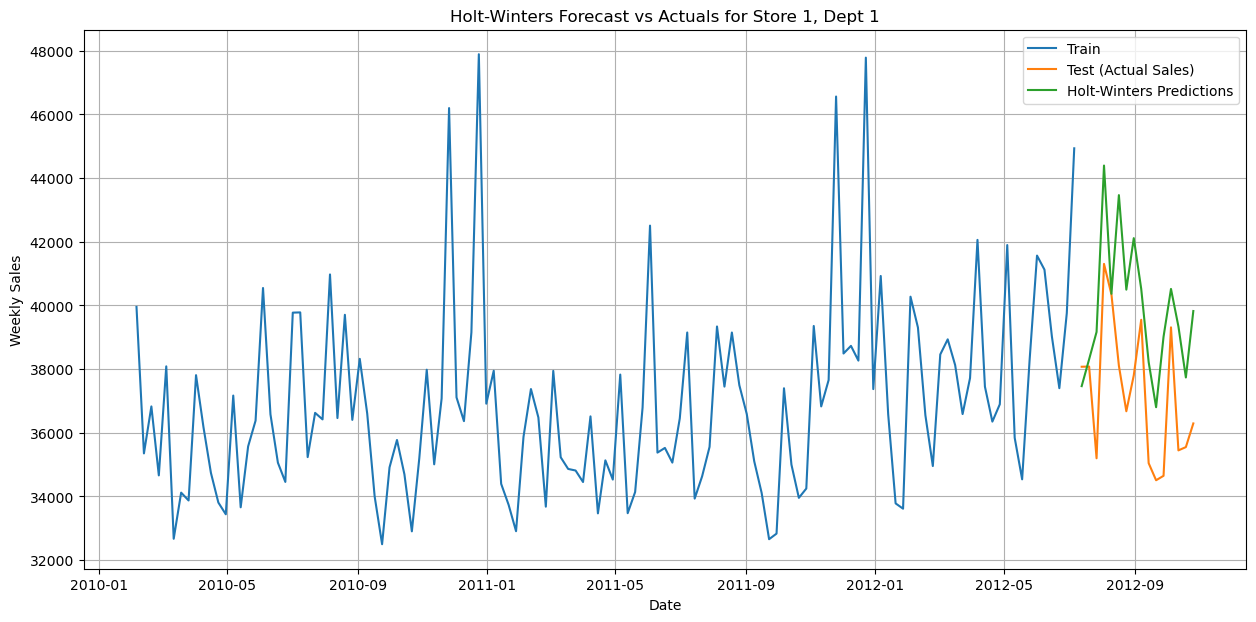

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters Model for Store 1, Dept 5:
RMSE: 3654.97
MAPE: 15.21%


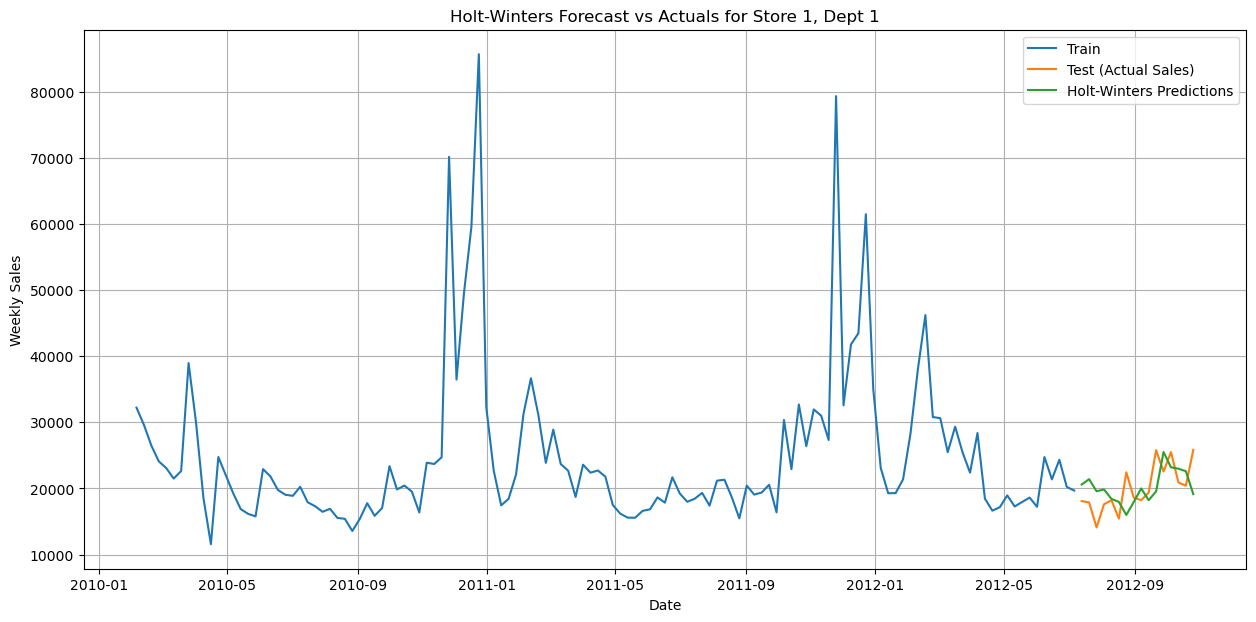

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters Model for Store 1, Dept 6:
RMSE: 1152.96
MAPE: 175.91%


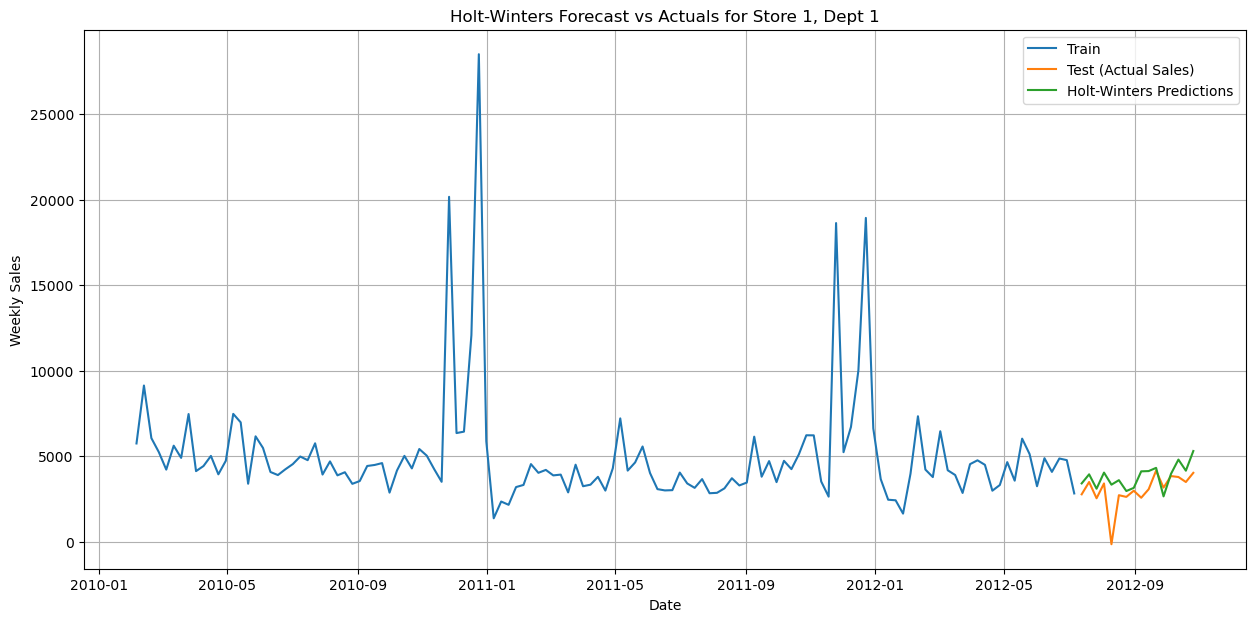

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters Model for Store 1, Dept 7:
RMSE: 4173.43
MAPE: 14.77%


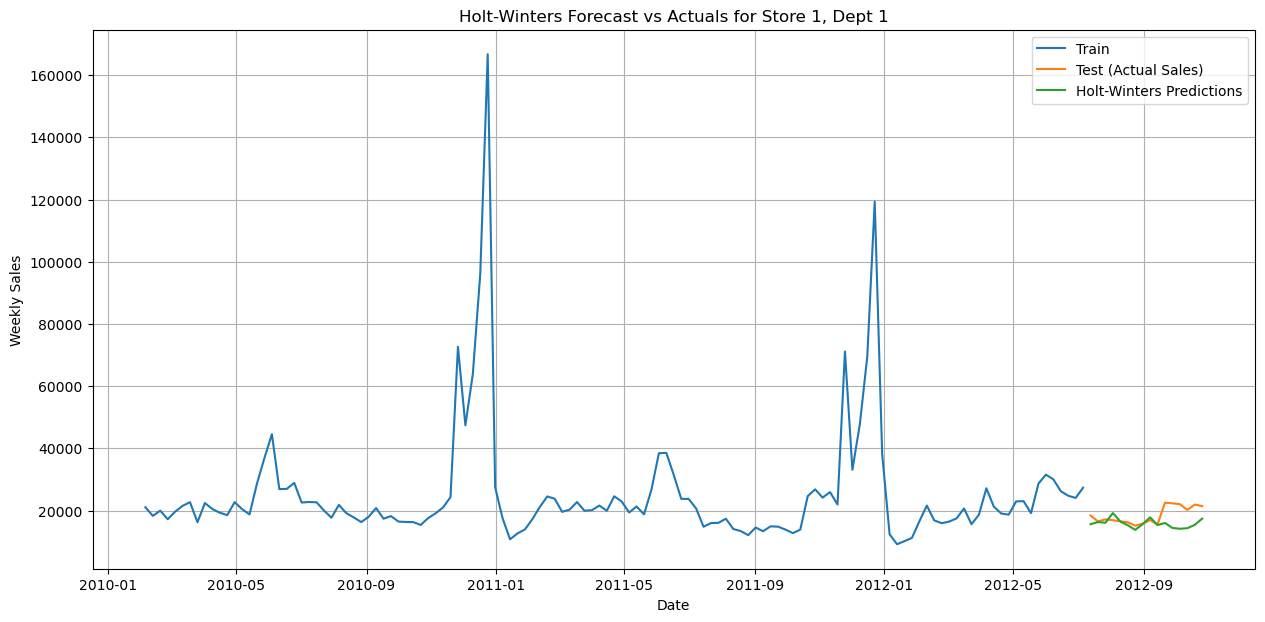

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters Model for Store 1, Dept 8:
RMSE: 2028.10
MAPE: 4.39%


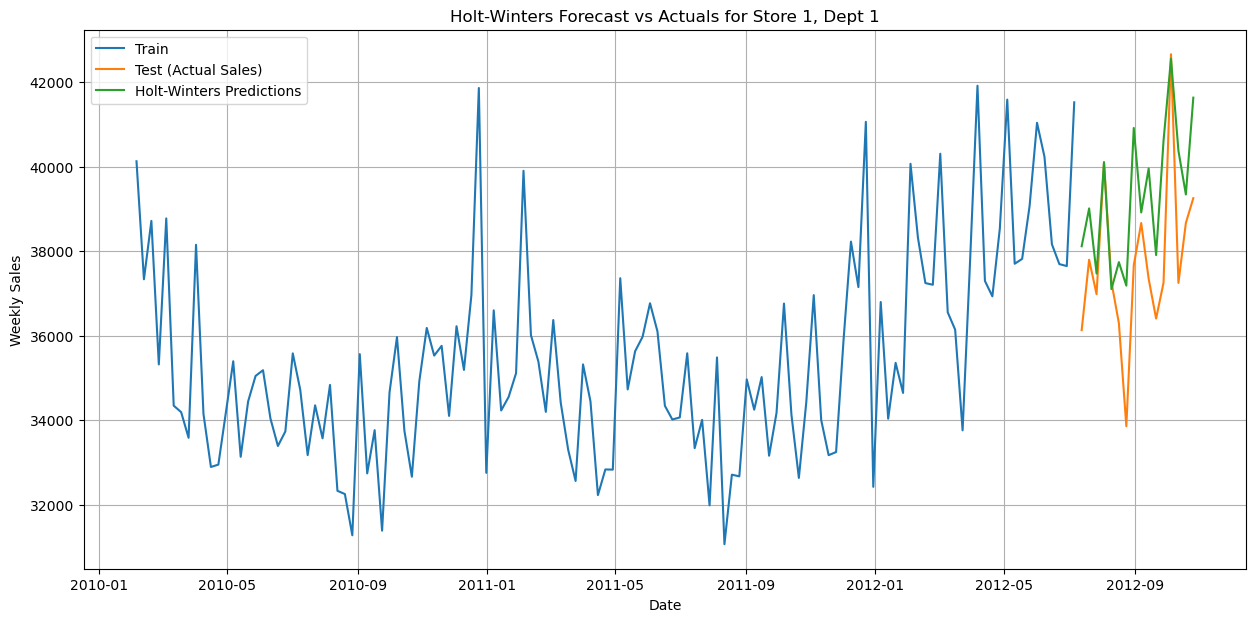

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters Model for Store 1, Dept 9:
RMSE: 3175.71
MAPE: 6.72%


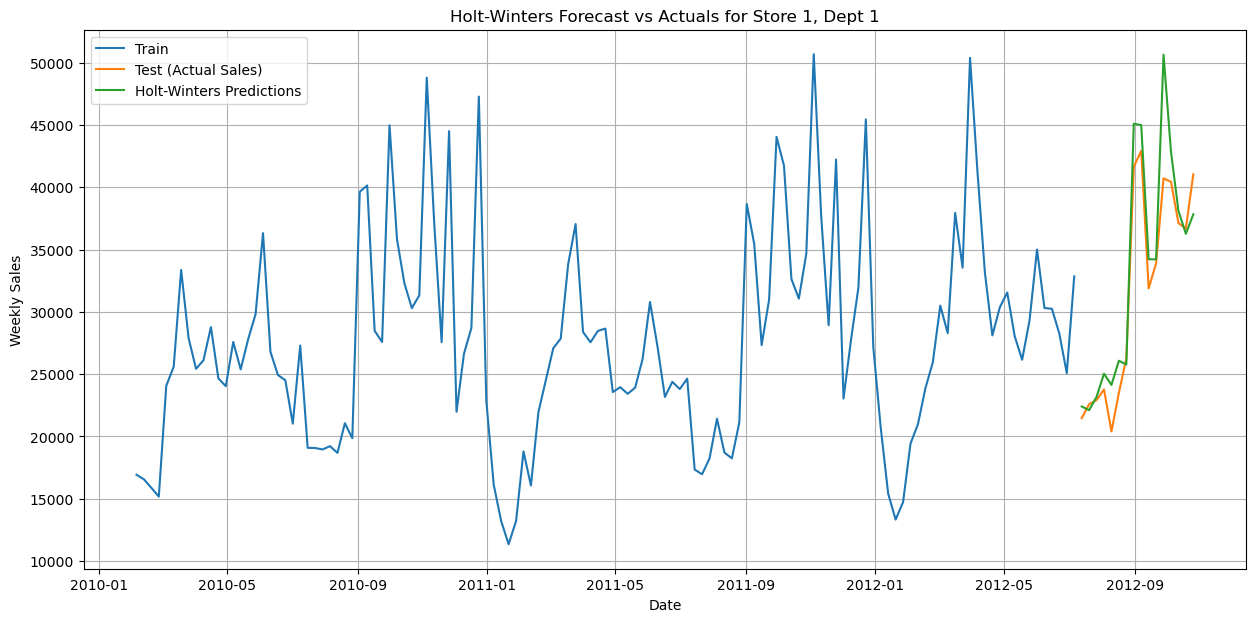

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters Model for Store 1, Dept 10:
RMSE: 5286.14
MAPE: 16.25%


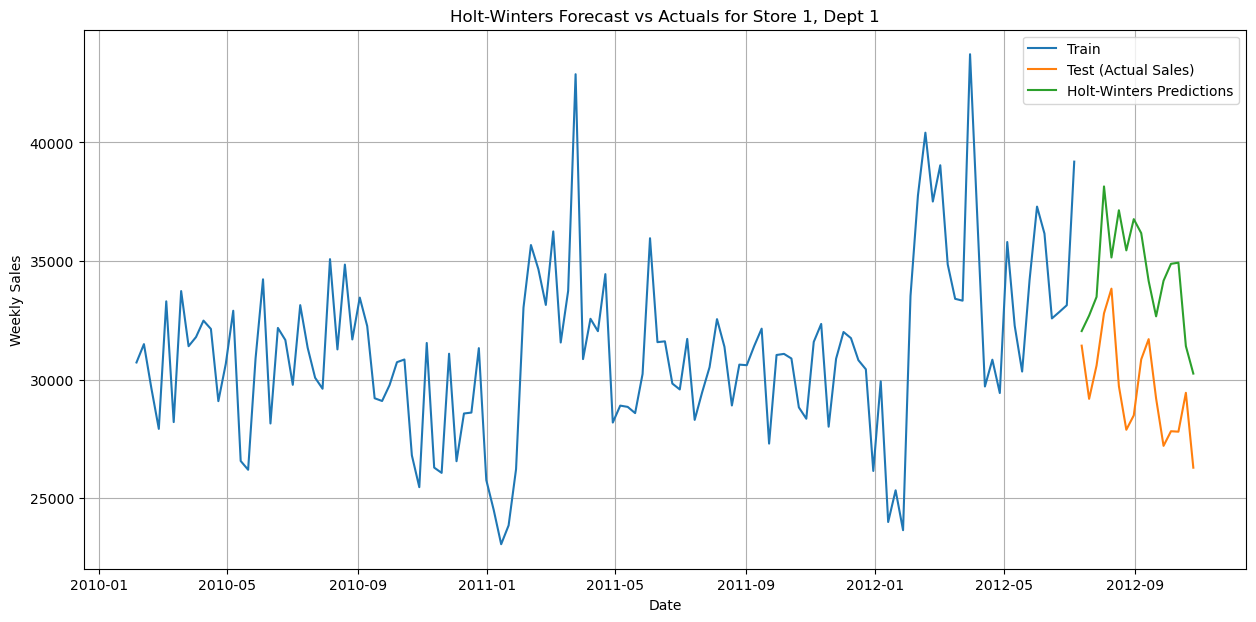

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/p

In [70]:
hw_results_df = pd.DataFrame(columns=['Store', 'Dept', 'RMSE', 'MAPE'])
unique_combinations = df[['Store', 'Dept']].drop_duplicates()
for idx, row in unique_combinations.iterrows():
    # print(f"Store: {row['Store']}, Dept: {row['Dept']}")
    hw_results = holtz_winter_model(df, row['Store'], row['Dept'])
    # Append the results as a new row to the DataFrame using pd.concat (recommended over .append)
    hw_results_df = pd.concat(
        [hw_results_df, pd.DataFrame([{
            'Store': hw_results[0],
            'Dept': hw_results[1],
            'RMSE': hw_results[2],
            'MAPE': hw_results[3]
        }])],
        ignore_index=True
    )

In [71]:
hw_results_df

Store Dept         RMSE      MAPE
0        1    1  2932.575727  0.069711
1        1    2  3819.113921  0.075029
2        1    3  8834.714303  0.189279
3        1    4  3131.637721  0.073517
4        1    5  3654.970161  0.152089
...    ...  ...          ...       ...
2655    45   91  1049.597680  0.049852
2656    45   92  2744.401532  0.040044
2657    45   93  1203.402103  0.398841
2658    45   95  4321.929809  0.060836
2659    45   97   532.526677  0.061320

[2660 rows x 4 columns]

## Sarima model

In [72]:
# --- 1. Prepare Data for the Store and Dept ---
# Filter data for the specific store and department
def sarimax_model(df, store, dept):
    # Filter data for Store and Dept
    s1d1 = df[(df['Store'] == store) & (df['Dept'] == dept)].copy()

    # Convert 'Date' to datetime and set as index, ensuring a weekly frequency
    s1d1['Date'] = pd.to_datetime(s1d1['Date'])
    s1d1 = s1d1.set_index('Date').asfreq('W-FRI') # Set frequency to weekly, ending on Friday

    # Separate train and test sets based on the 'Set' column
    train_s1d1 = s1d1[s1d1['Set'] == 'train']['Weekly_Sales']
    test_s1d1 = s1d1[s1d1['Set'] == 'test']['Weekly_Sales']


    # --- 2. Build and Train SARIMA Model ---
    # Define the model parameters (p,d,q) and seasonal parameters (P,D,Q,s)
    # These are common starting points and can be tuned further with grid search
    sarima_order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 52) # s=52 for yearly seasonality on weekly data

    # Create and fit the SARIMA model
    sarima_model = SARIMAX(train_s1d1,
                        order=sarima_order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)
    

    # --- 3. Make Predictions ---
    # Forecast for the same number of steps as the test set
    predictions = sarima_model.forecast(steps=len(test_s1d1))


    # --- 4. Evaluate the Model ---
    rmse = np.sqrt(mean_squared_error(test_s1d1, predictions))
    mape = mean_absolute_percentage_error(test_s1d1, predictions)




    # --- 5. Plot the Results ---
    if store == 1 and dept <= 10:
        print(f"\nSARIMA Model Evaluation for Store {store}, Dept {dept}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2%}")
        print(sarima_model.summary())
        plt.figure(figsize=(18, 8))
        plt.plot(train_s1d1.index, train_s1d1, label='Training Data')
        plt.plot(test_s1d1.index, test_s1d1, label='Test Data (Actual Sales)', color='orange')
        plt.plot(predictions.index, predictions, label='SARIMA Predictions', color='green', linestyle='--')

        plt.title('SARIMA Forecast vs Actuals for Store 1, Dept 1', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Weekly Sales', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    results = [store, dept, rmse, mape]
    return results



/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



SARIMA Model Evaluation for Store 1, Dept 1:
RMSE: 1891.79
MAPE: 4.54%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -209.675
Date:                            Sun, 28 Sep 2025   AIC                            429.350
Time:                                    10:51:38   BIC                            434.329
Sample:                                02-05-2010   HQIC                           430.322
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0029      0.340      0.00

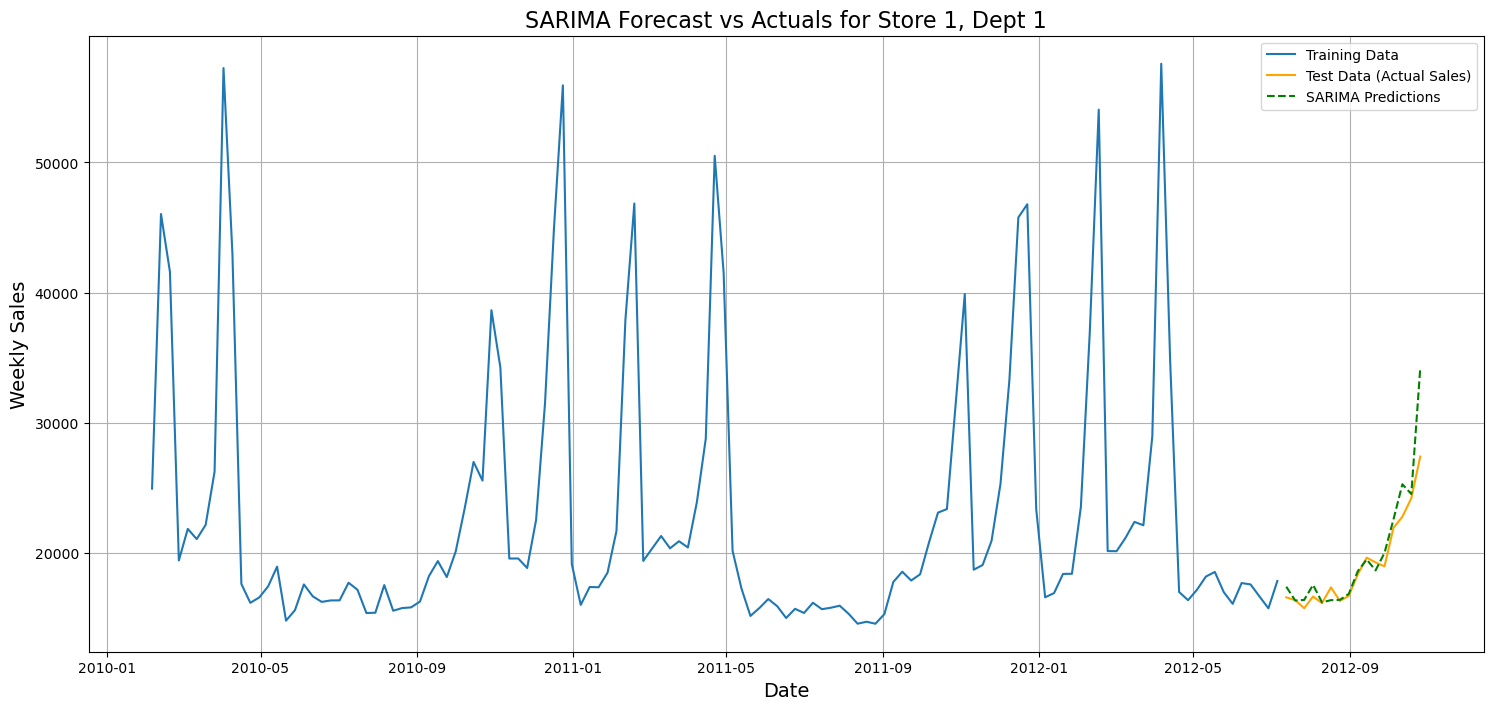

/var/folders/c7/9xbj4rnx7mj0nftwxf44my6m0000gp/T/ipykernel_90579/1239368564.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sa_results_df = pd.concat(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



SARIMA Model Evaluation for Store 1, Dept 2:
RMSE: 1903.54
MAPE: 3.50%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -174.368
Date:                            Sun, 28 Sep 2025   AIC                            358.737
Time:                                    10:51:52   BIC                            363.715
Sample:                                02-05-2010   HQIC                           359.709
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0301      0.385     -0.07

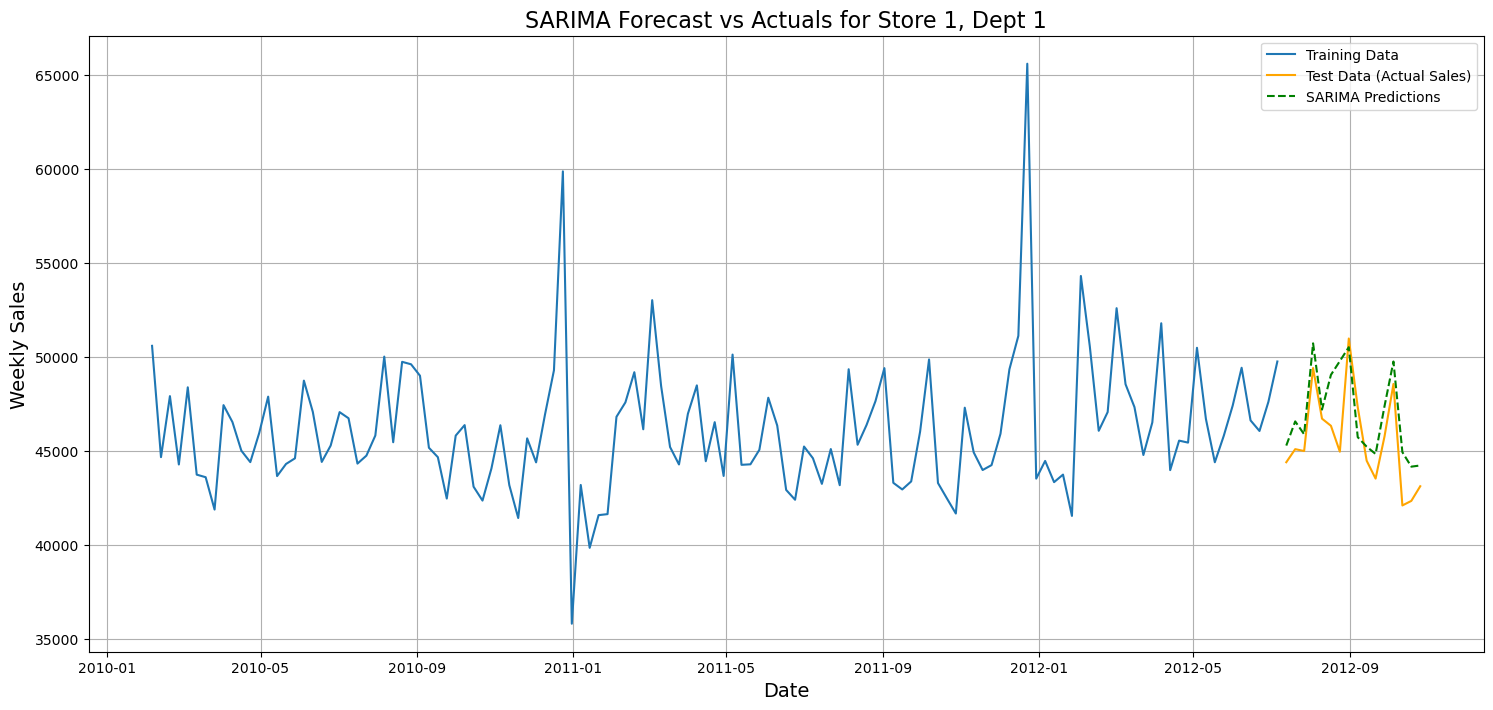

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



SARIMA Model Evaluation for Store 1, Dept 3:
RMSE: 8552.09
MAPE: 18.99%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -165.282
Date:                            Sun, 28 Sep 2025   AIC                            340.565
Time:                                    10:51:57   BIC                            345.543
Sample:                                02-05-2010   HQIC                           341.537
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1988      0.696     -0.2

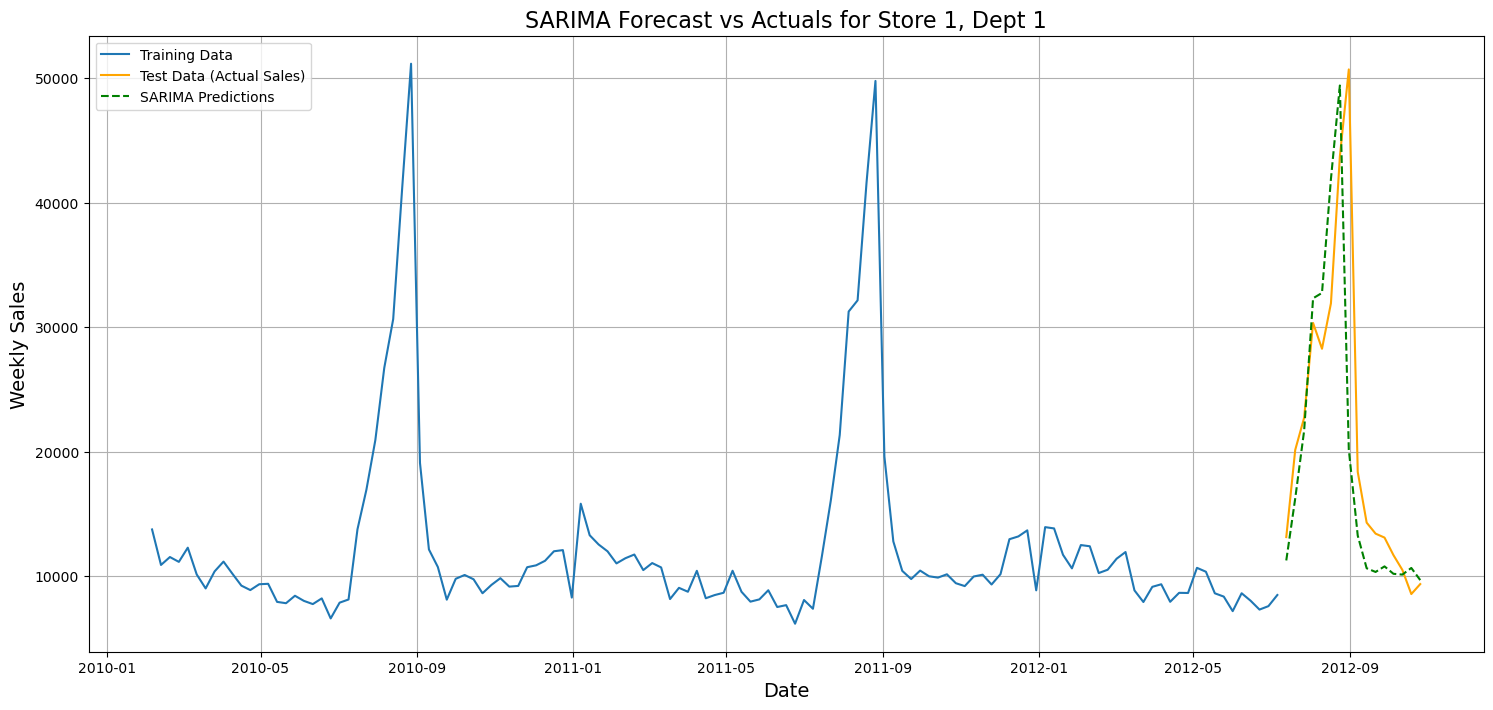

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



SARIMA Model Evaluation for Store 1, Dept 4:
RMSE: 1905.08
MAPE: 4.23%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -177.764
Date:                            Sun, 28 Sep 2025   AIC                            365.528
Time:                                    10:52:00   BIC                            370.506
Sample:                                02-05-2010   HQIC                           366.500
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1355      0.328      0.41

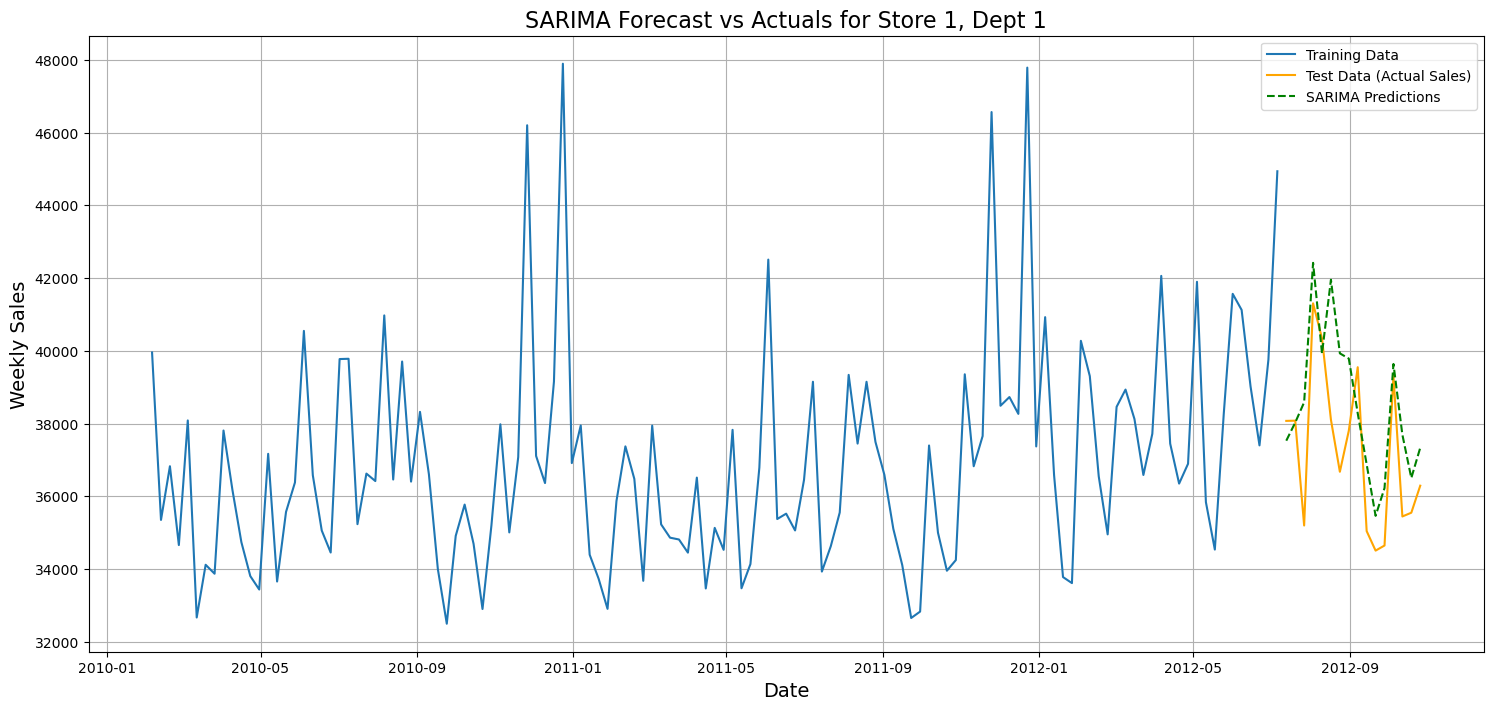

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMA Model Evaluation for Store 1, Dept 5:
RMSE: 3127.10
MAPE: 13.34%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -186.173
Date:                            Sun, 28 Sep 2025   AIC                            382.346
Time:                                    10:52:13   BIC                            387.325
Sample:                                02-05-2010   HQIC                           383.318
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0450      0.285     -0.1

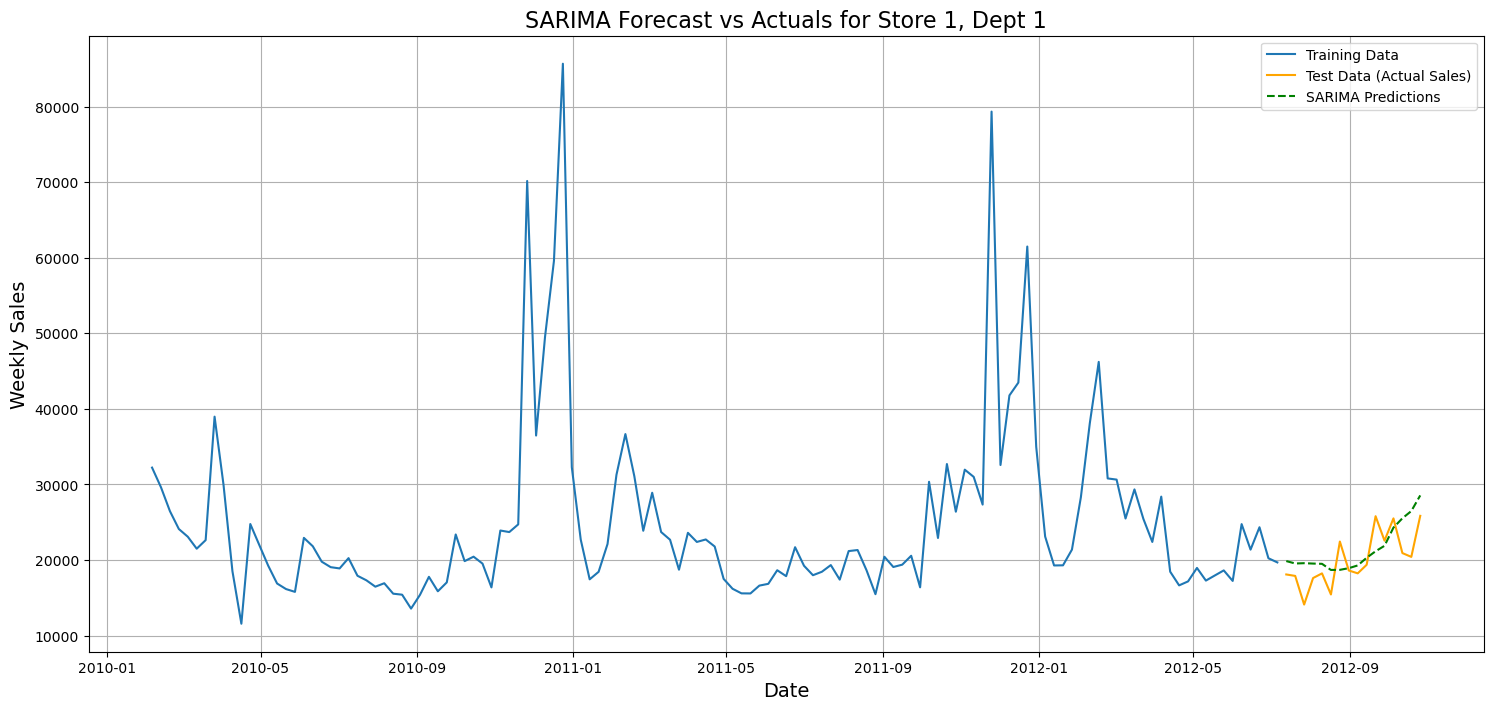

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMA Model Evaluation for Store 1, Dept 6:
RMSE: 1825.25
MAPE: 194.42%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -168.236
Date:                            Sun, 28 Sep 2025   AIC                            346.471
Time:                                    10:52:24   BIC                            351.450
Sample:                                02-05-2010   HQIC                           347.443
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2440      0.295      0.

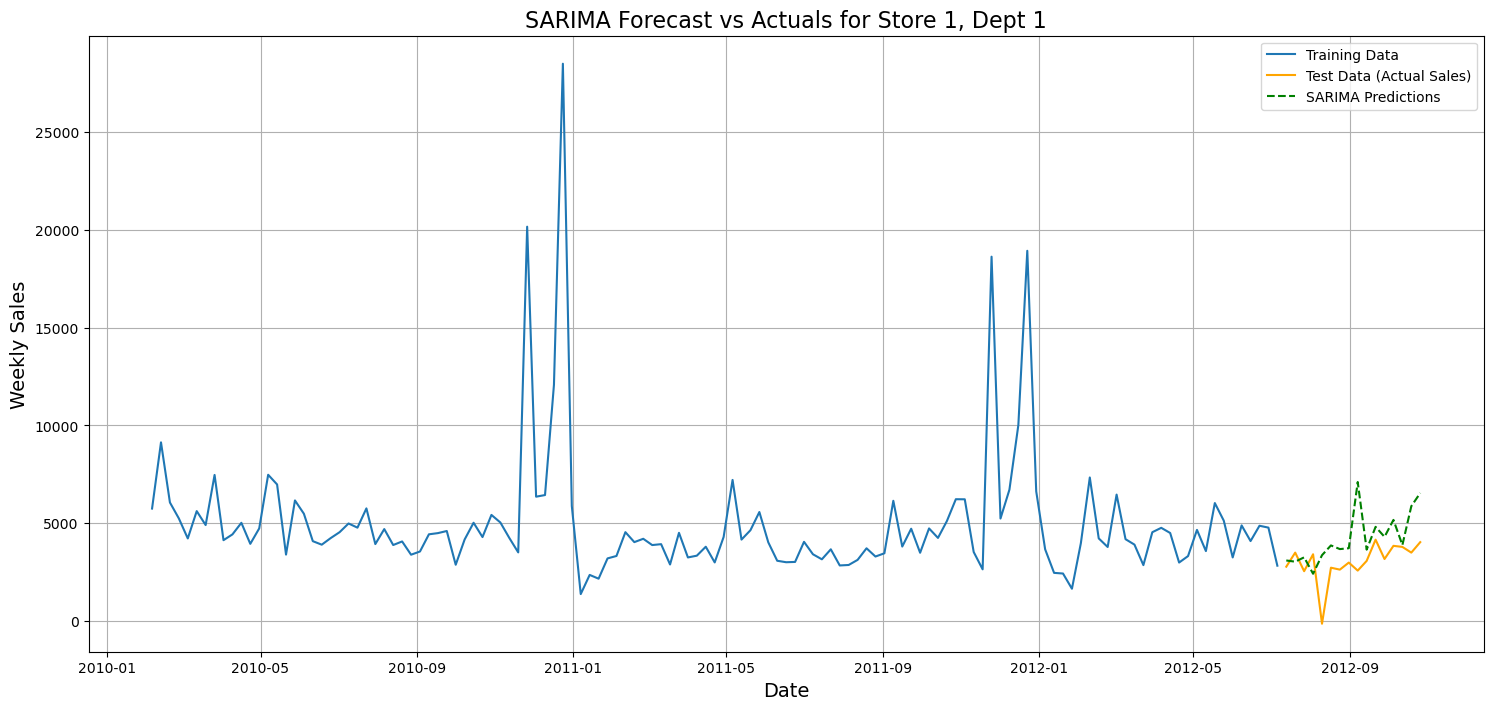

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMA Model Evaluation for Store 1, Dept 7:
RMSE: 7017.13
MAPE: 37.45%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -191.654
Date:                            Sun, 28 Sep 2025   AIC                            393.308
Time:                                    10:52:35   BIC                            398.287
Sample:                                02-05-2010   HQIC                           394.280
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5848      0.197     -2.9

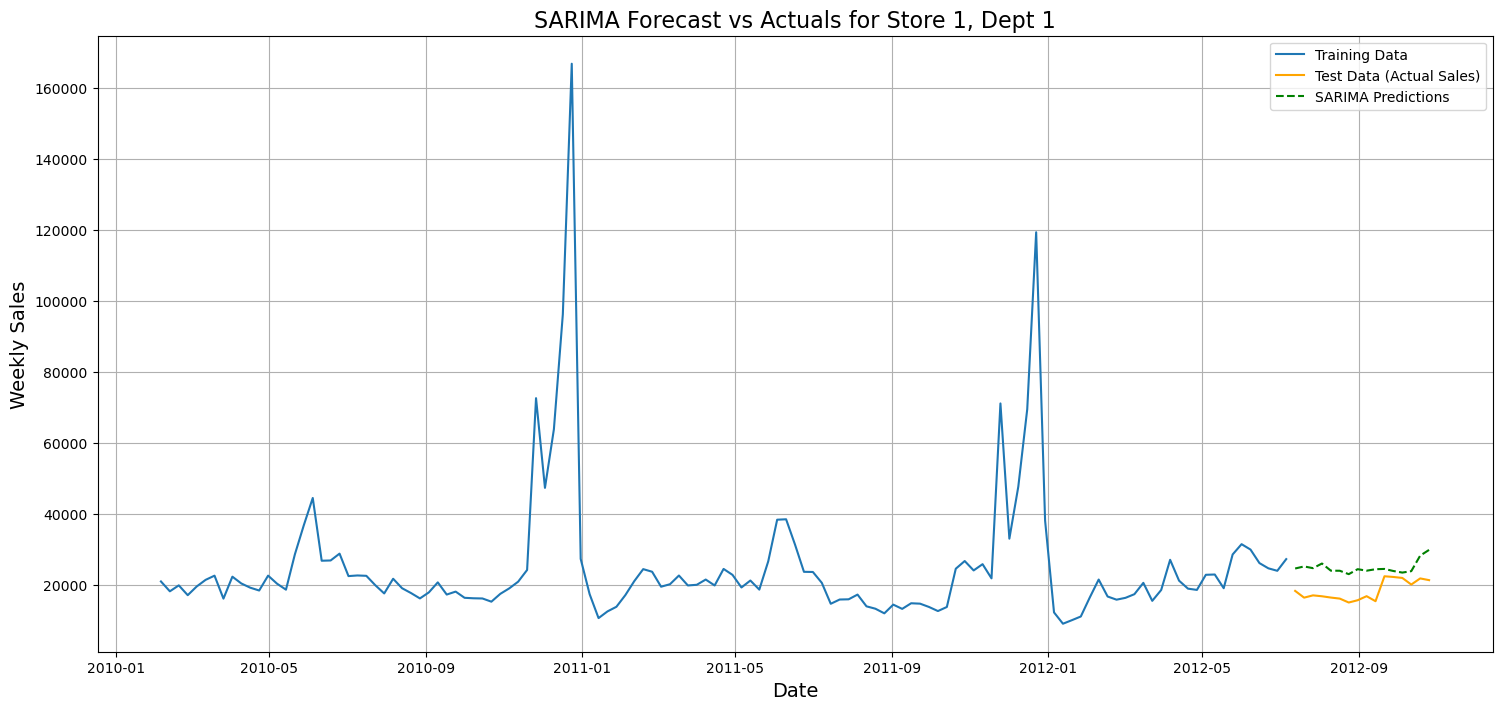

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



SARIMA Model Evaluation for Store 1, Dept 8:
RMSE: 1460.40
MAPE: 3.31%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -173.196
Date:                            Sun, 28 Sep 2025   AIC                            356.392
Time:                                    10:52:39   BIC                            361.370
Sample:                                02-05-2010   HQIC                           357.364
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3480      0.706      0.49

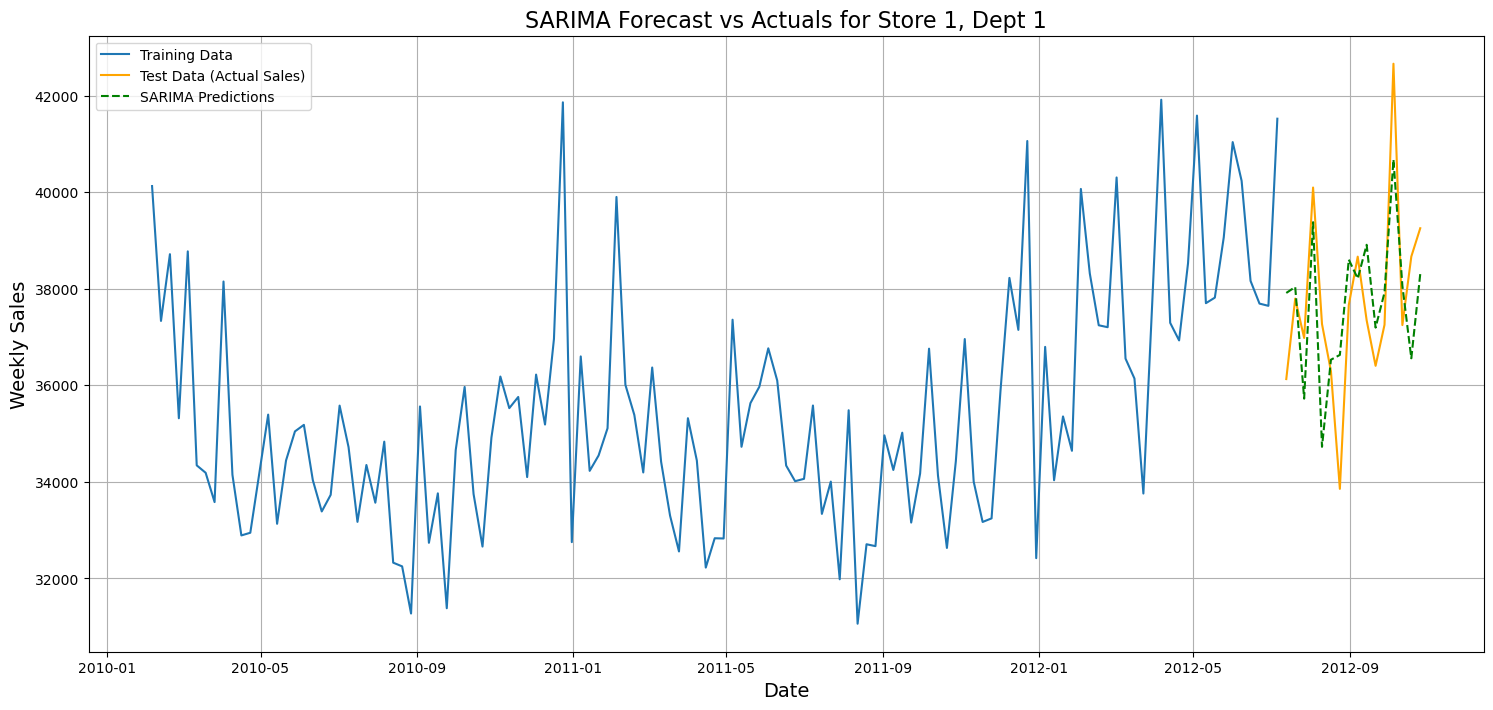

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



SARIMA Model Evaluation for Store 1, Dept 9:
RMSE: 6679.81
MAPE: 21.44%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -198.330
Date:                            Sun, 28 Sep 2025   AIC                            406.660
Time:                                    10:52:42   BIC                            411.639
Sample:                                02-05-2010   HQIC                           407.632
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6498      0.199      3.2

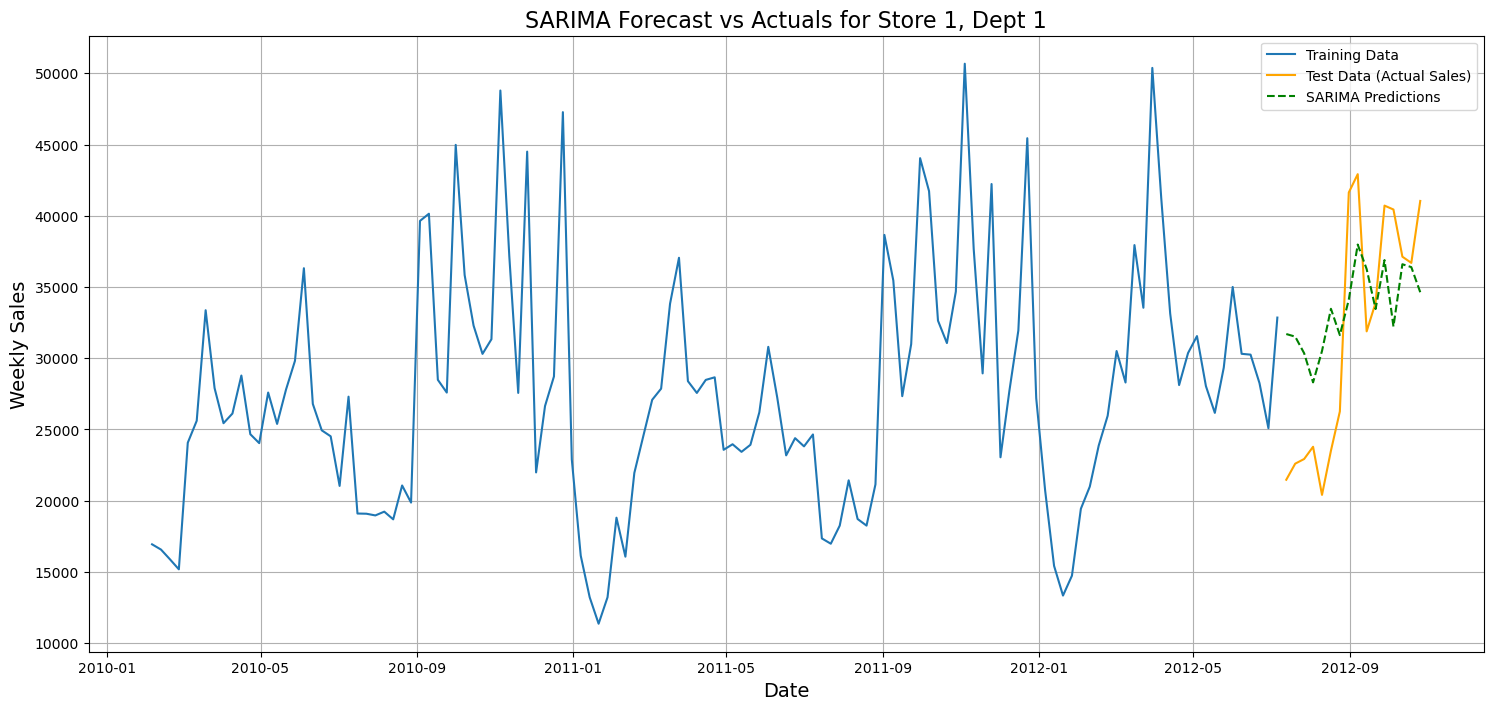

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



SARIMA Model Evaluation for Store 1, Dept 10:
RMSE: 4807.99
MAPE: 15.64%
                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -190.875
Date:                            Sun, 28 Sep 2025   AIC                            391.750
Time:                                    10:52:45   BIC                            396.729
Sample:                                02-05-2010   HQIC                           392.722
                                     - 07-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1393      0.481      0.

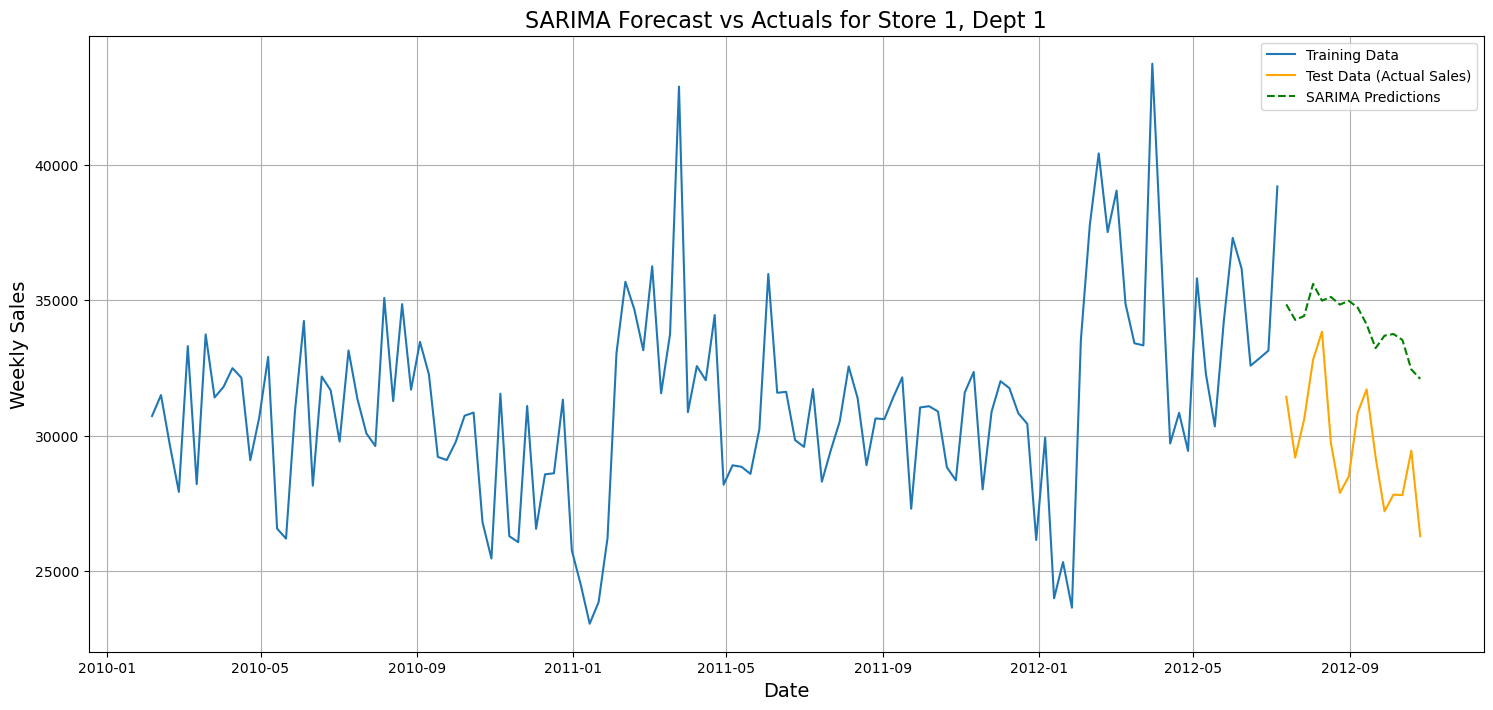

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observa

In [75]:
sa_results_df = pd.DataFrame(columns=['Store', 'Dept', 'RMSE', 'MAPE'])
unique_combinations = df[['Store', 'Dept']].drop_duplicates()
unique_combinations = unique_combinations.head(20)
for idx, row in unique_combinations.iterrows():
    # print(f"Store: {row['Store']}, Dept: {row['Dept']}")
    sa_results = sarimax_model(df, row['Store'], row['Dept'])
    # Append the results as a new row to the DataFrame using pd.concat (recommended over .append)
    sa_results_df = pd.concat(
        [sa_results_df, pd.DataFrame([{
            'Store': sa_results[0],
            'Dept': sa_results[1],
            'RMSE': sa_results[2],
            'MAPE': sa_results[3]
        }])],
        ignore_index=True
    )

In [76]:
sa_results_df

Store Dept         RMSE      MAPE
0      1    1  1891.792368  0.045438
1      1    2  1903.544013  0.035033
2      1    3  8552.086781  0.189873
3      1    4  1905.075744  0.042277
4      1    5  3127.104362  0.133402
5      1    6  1825.250931  1.944201
6      1    7  7017.131621  0.374545
7      1    8  1460.403748  0.033107
8      1    9  6679.811545  0.214405
9      1   10  4807.987566  0.156417
10     1   11  3517.582912  0.127031
11     1   12  1595.125310  0.131674
12     1   13  2064.216762  0.041498
13     1   14  2814.183685  0.217952
14     1   16  6211.662369  0.368068
15     1   17   625.498384  0.063601
16     1   19   421.657971  0.364039
17     1   20   526.915878  0.120068
18     1   21   697.158199  0.084885
19     1   22  1162.735425  0.137647

## Seasonality Decomposition of data 

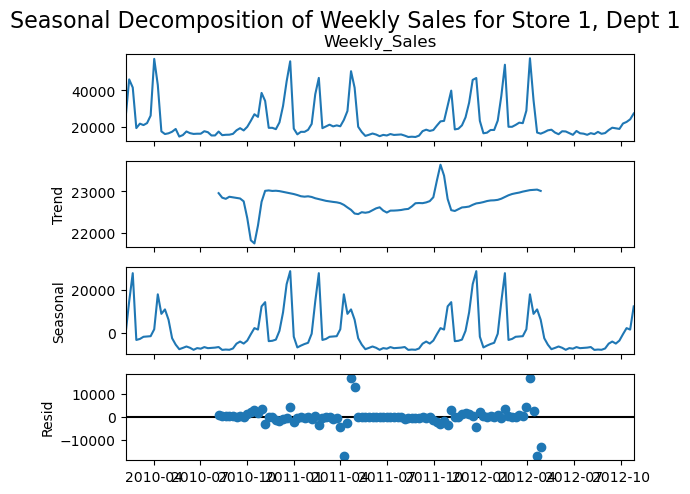

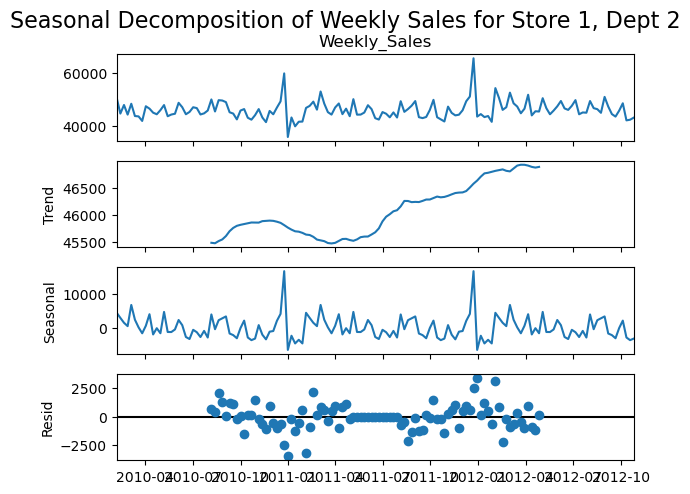

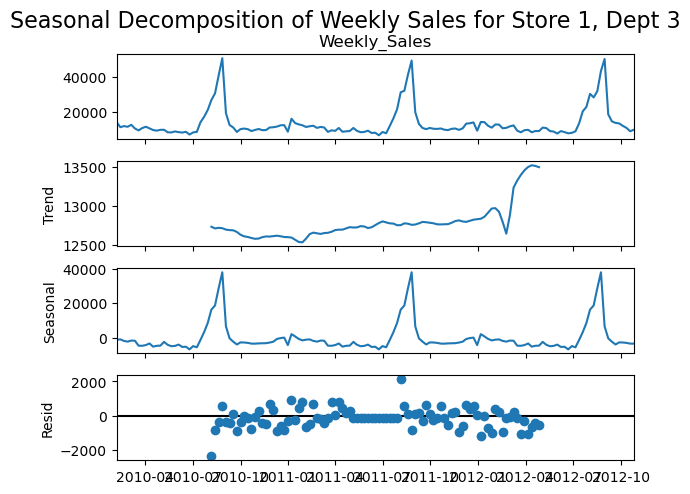

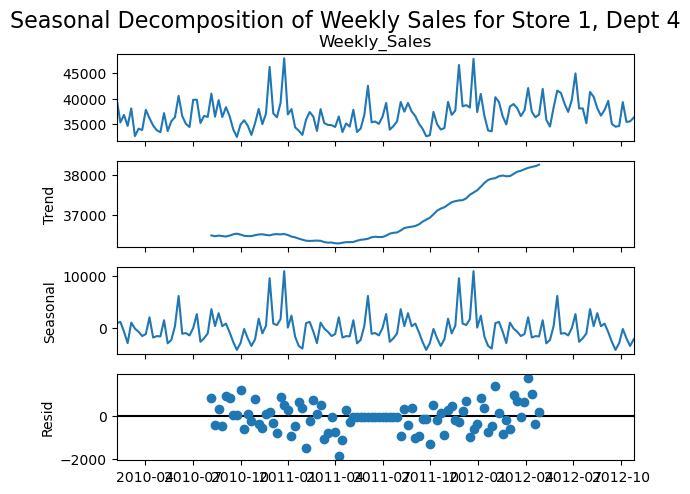

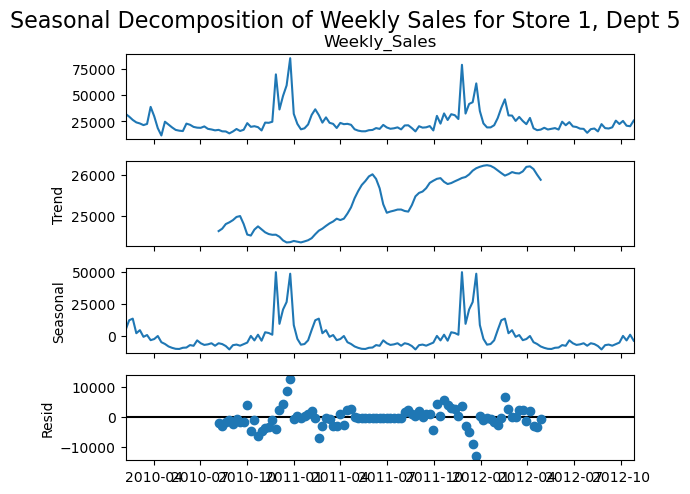

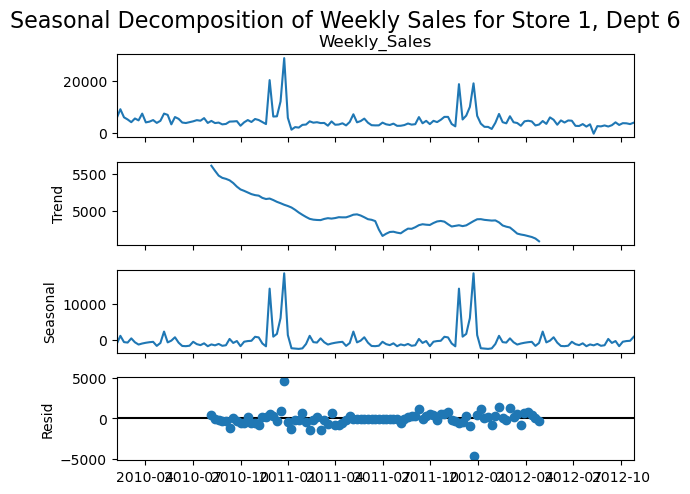

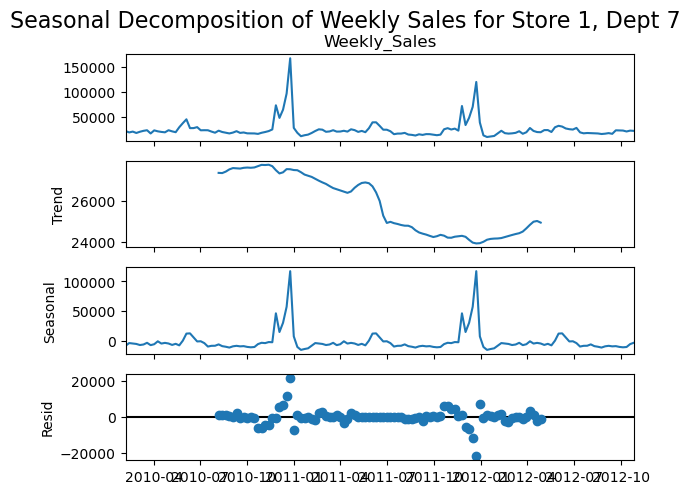

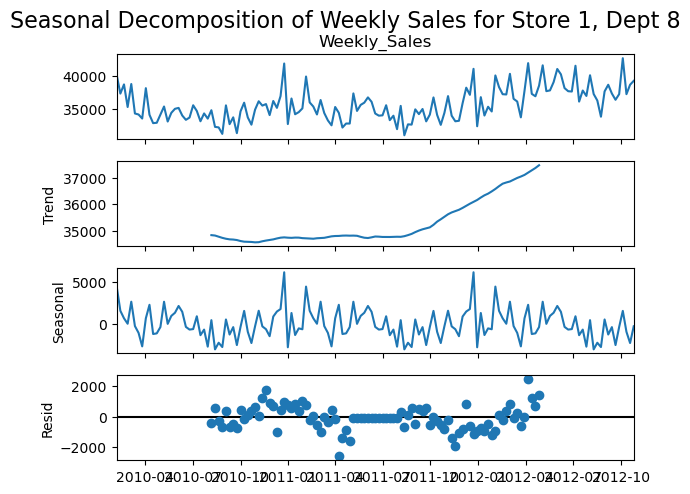

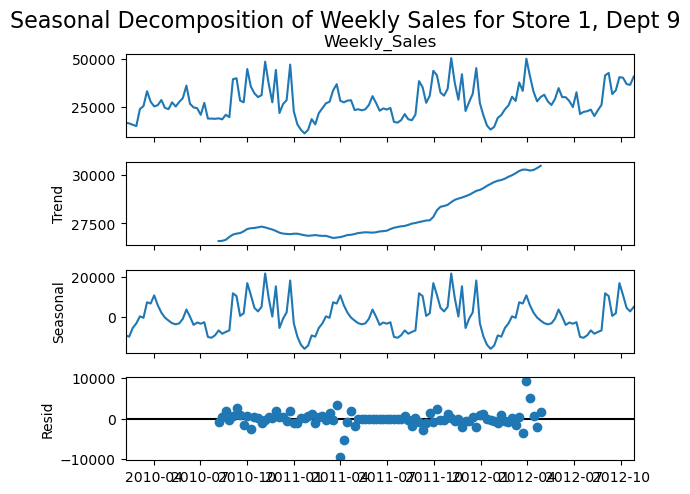

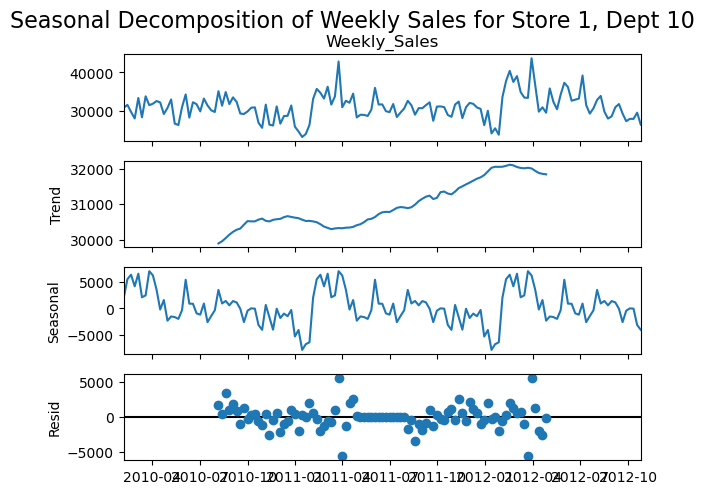

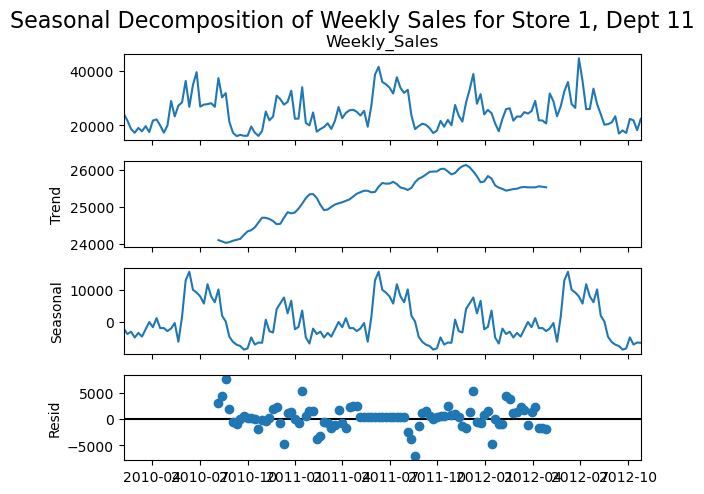

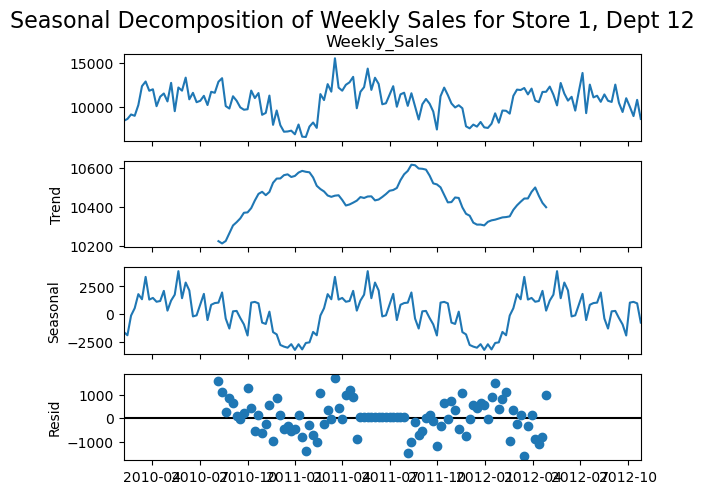

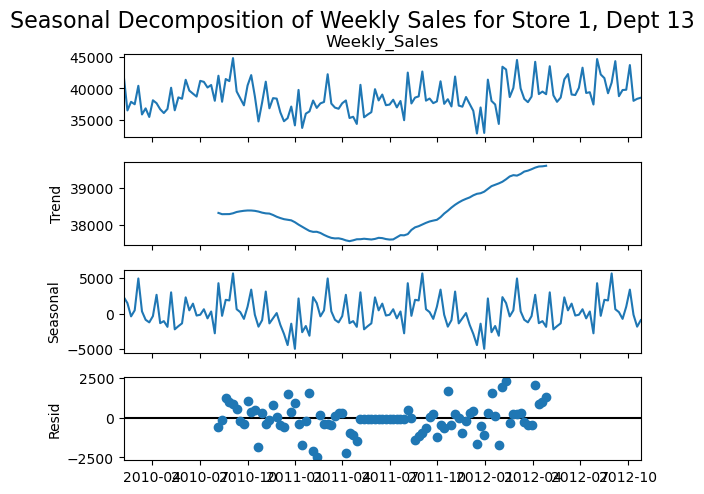

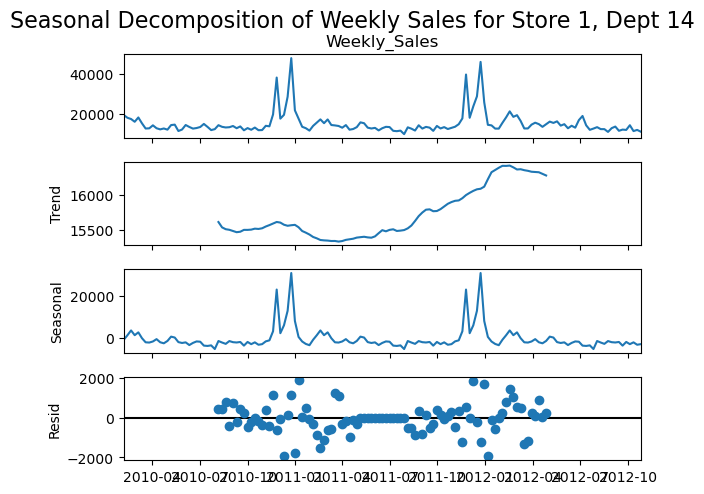

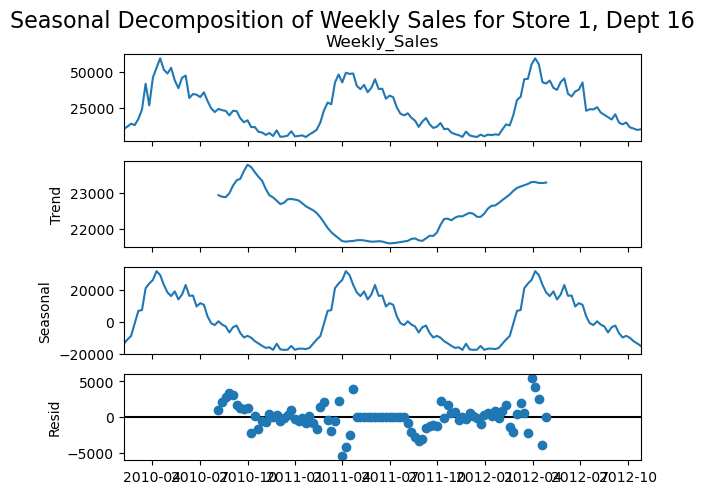

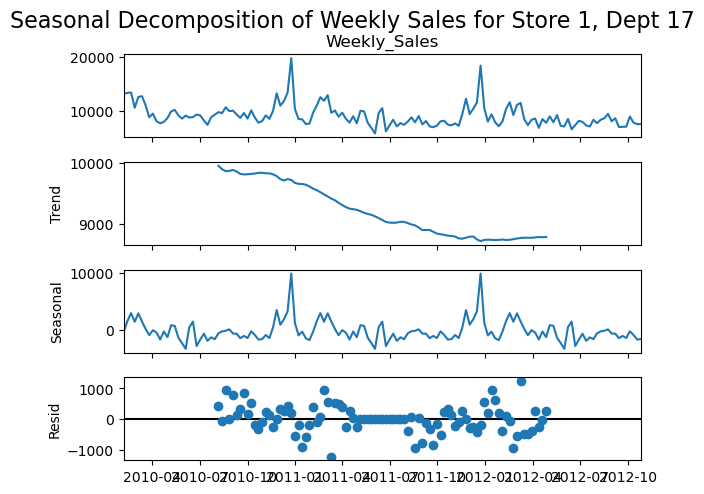

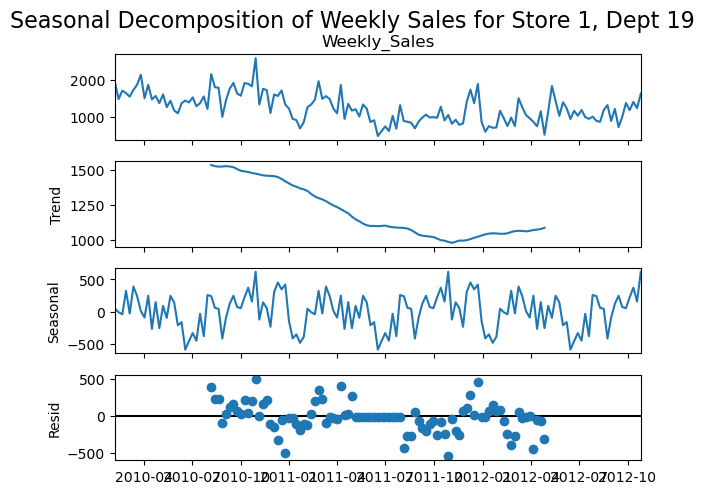

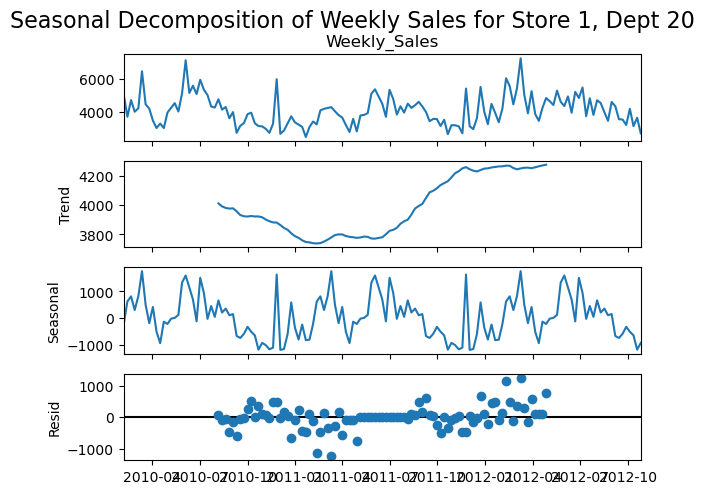

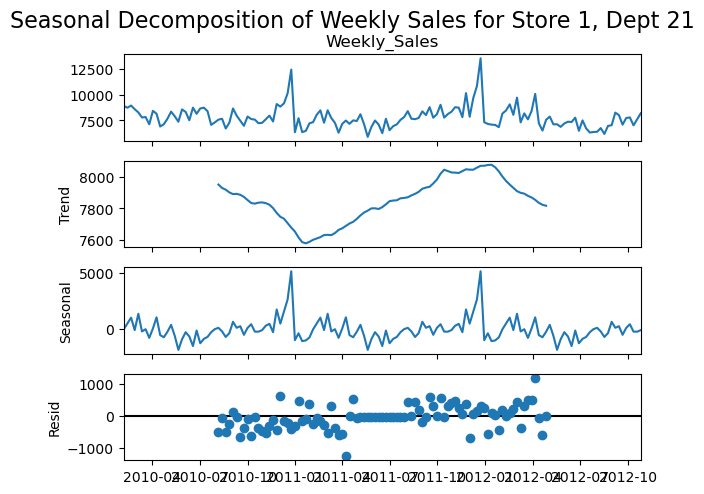

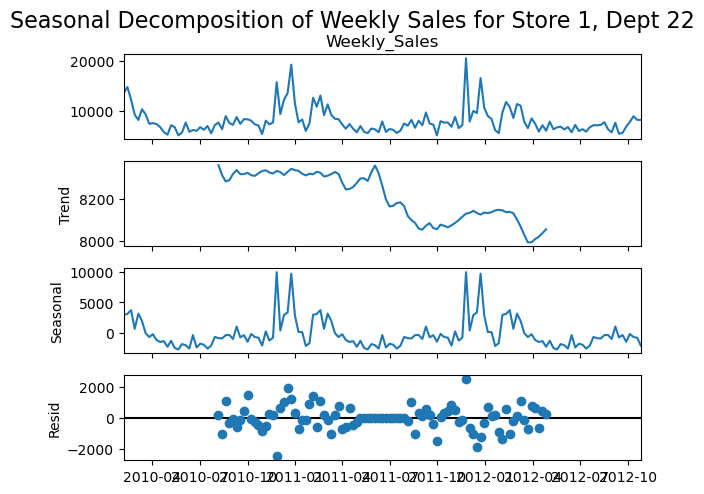

In [13]:
unique_combinations = df[['Store', 'Dept']].drop_duplicates()
unique_combinations = unique_combinations.head(20)
for idx, row in unique_combinations.iterrows():
    # Filter data for the specific store and department
    sd_decomp = df[(df['Store'] == row['Store']) & (df['Dept'] == row['Dept'])].copy()

    # Convert 'Date' to datetime and set it as the index
    sd_decomp['Date'] = pd.to_datetime(sd_decomp['Date'])
    sd_decomp = sd_decomp.set_index('Date')

    # Select the 'Weekly_Sales' column and ensure it has a weekly frequency
    ts_data = sd_decomp['Weekly_Sales'].asfreq('W-FRI')

    # Using an additive model, assuming the seasonal fluctuations are roughly constant
    # period=52 for weekly data with a yearly cycle
    decomposition = seasonal_decompose(ts_data, model='additive', period=52)

    fig = decomposition.plot()
    plt.suptitle(f"Seasonal Decomposition of Weekly Sales for Store {row['Store']}, Dept {row['Dept']}", y=1.02, fontsize=16)
    plt.show()

